In [2]:
import pandas as pd

path = "/content/online_retail_II.xlsx"

# 2. Load the data (Using both years)

print("🔄 Loading data... please wait.")
df_2009 = pd.read_excel(path, sheet_name="Year 2009-2010")
df_2010 = pd.read_excel(path, sheet_name="Year 2010-2011")


df = pd.concat([df_2009, df_2010], ignore_index=True)

# Auditng and profiling the data.
print("✅ Data Loaded Successfully!")
print(f"Total Records: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")

# Checking for missing values in critical BA fields
print("\n🔍 Missing Value Audit:")
print(df[['Customer ID', 'Description', 'Price']].isnull().sum())

🔄 Loading data... please wait.
✅ Data Loaded Successfully!
Total Records: 1067371
Total Columns: 8

🔍 Missing Value Audit:
Customer ID    243007
Description      4382
Price               0
dtype: int64


In [3]:
# Filtering out missing Customer IDs for behavior analysis
df_clean = df.dropna(subset=['Customer ID']).copy()

#  Ensuring Date is in the right format for Time-Series Analysis
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Calculating TotalRevenue before separating sales and returns
df_clean['TotalRevenue'] = df_clean['Quantity'] * df_clean['Price']

#  Separating Transactions from Returns
sales = df_clean[df_clean['Quantity'] > 0].copy()
returns = df_clean[df_clean['Quantity'] < 0].copy()


total_revenue = sales['TotalRevenue'].sum()
unique_orders = sales['Invoice'].nunique()
unique_customers = sales['Customer ID'].nunique()
aov = total_revenue / unique_orders # Average Order Value
return_rate = (returns['Quantity'].abs().sum() / sales['Quantity'].sum()) * 100

print(f"--- BUSINESS HEALTH SUMMARY ---")
print(f"Total Revenue: £{total_revenue:,.2f}")
print(f"Average Order Value (AOV): £{aov:.2f}")
print(f"Unique Customers: {unique_customers}")
print(f"Return Rate: {return_rate:.2f}%")

--- BUSINESS HEALTH SUMMARY ---
Total Revenue: £17,743,429.18
Average Order Value (AOV): £479.88
Unique Customers: 5881
Return Rate: 4.54%


In [4]:
# Defining 'today' as the day after the last transaction in the dataset
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = sales.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalRevenue': 'sum'
})


rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Create 1-5 scores: 5 is the best
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combined Score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print("✅ RFM Segmentation Complete!")
rfm.head()

✅ RFM Segmentation Complete!


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment
Customer ID,,,,,,,
12346.0,326,12,77556.46,2,5,5,255
12347.0,2,8,5633.32,5,4,5,545
12348.0,75,5,2019.40,3,4,4,344
12349.0,19,4,4428.69,5,3,5,535
12350.0,310,1,334.40,2,1,2,212


In [5]:
# 1. Reset index of rfm so 'Customer ID' becomes a column again
rfm_reset = rfm.reset_index()

# 2. Merge RFM segments back into the main sales dataframe
df_final = pd.merge(sales, rfm_reset[['Customer ID', 'RFM_Segment', 'R_Score', 'F_Score', 'M_Score']],
                     on='Customer ID', how='left')

# 3. Create a 'Seasonality' feature
df_final['Month_Year'] = df_final['InvoiceDate'].dt.to_period('M').astype(str)

# 4. Export to CSV for Tableau
df_final.to_csv('online_retail_tableau.csv', index=False)

print("Success..")


Success..


In [15]:
from prophet import Prophet

# Prepare data for Prophet
# We will forecast TOTAL daily sales for the entire store
daily_sales = sales.groupby('InvoiceDate')['TotalRevenue'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

# Initialize and Fit the Model
model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(daily_sales)

# Create a future dataframe for the next 90 days
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-12-01 07:45:00,396.758830,-1220.180120,2267.433755,396.758830,396.758830,85.153264,85.153264,85.153264,64.687508,64.687508,64.687508,20.465756,20.465756,20.465756,0.0,0.0,0.0,481.912094
1,2009-12-01 07:46:00,396.759246,-1258.065243,2213.822667,396.759246,396.759246,85.185430,85.185430,85.185430,64.708258,64.708258,64.708258,20.477172,20.477172,20.477172,0.0,0.0,0.0,481.944676
2,2009-12-01 09:06:00,396.792541,-1398.748364,2216.162584,396.792541,396.792541,87.758558,87.758558,87.758558,66.369882,66.369882,66.369882,21.388676,21.388676,21.388676,0.0,0.0,0.0,484.551100
3,2009-12-01 09:08:00,396.793374,-1367.511488,2460.044421,396.793374,396.793374,87.822609,87.822609,87.822609,66.411191,66.411191,66.411191,21.411419,21.411419,21.411419,0.0,0.0,0.0,484.615983
4,2009-12-01 09:24:00,396.800033,-1265.661778,2182.118770,396.800033,396.800033,88.333949,88.333949,88.333949,66.740670,66.740670,66.740670,21.593280,21.593280,21.593280,0.0,0.0,0.0,485.133982


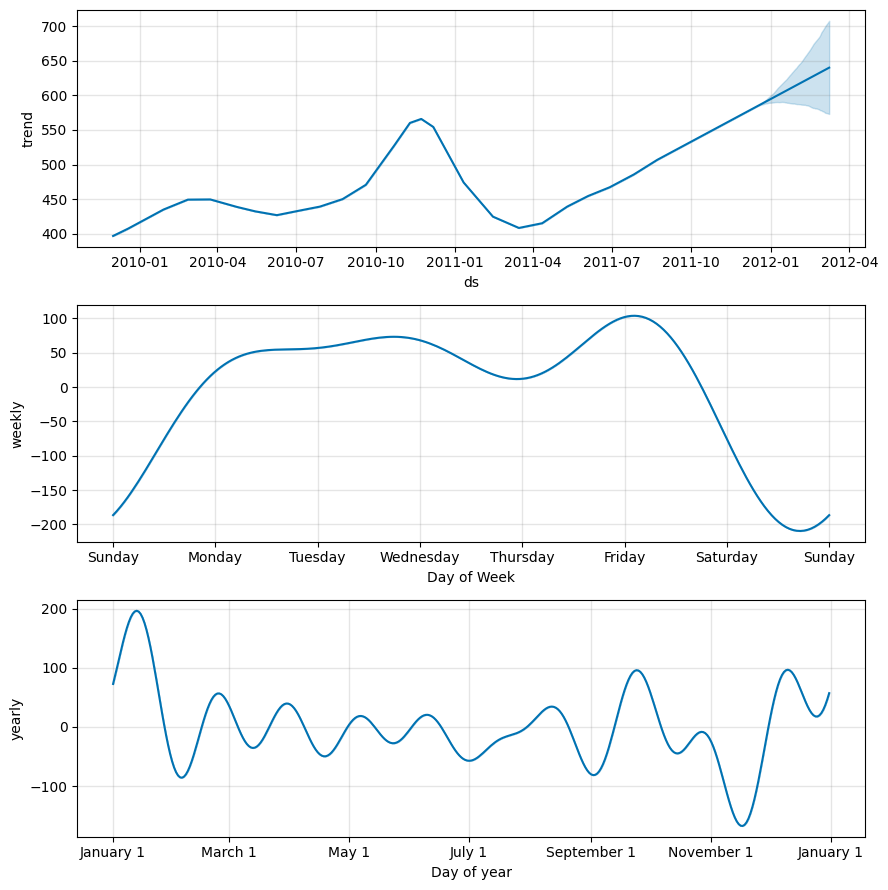

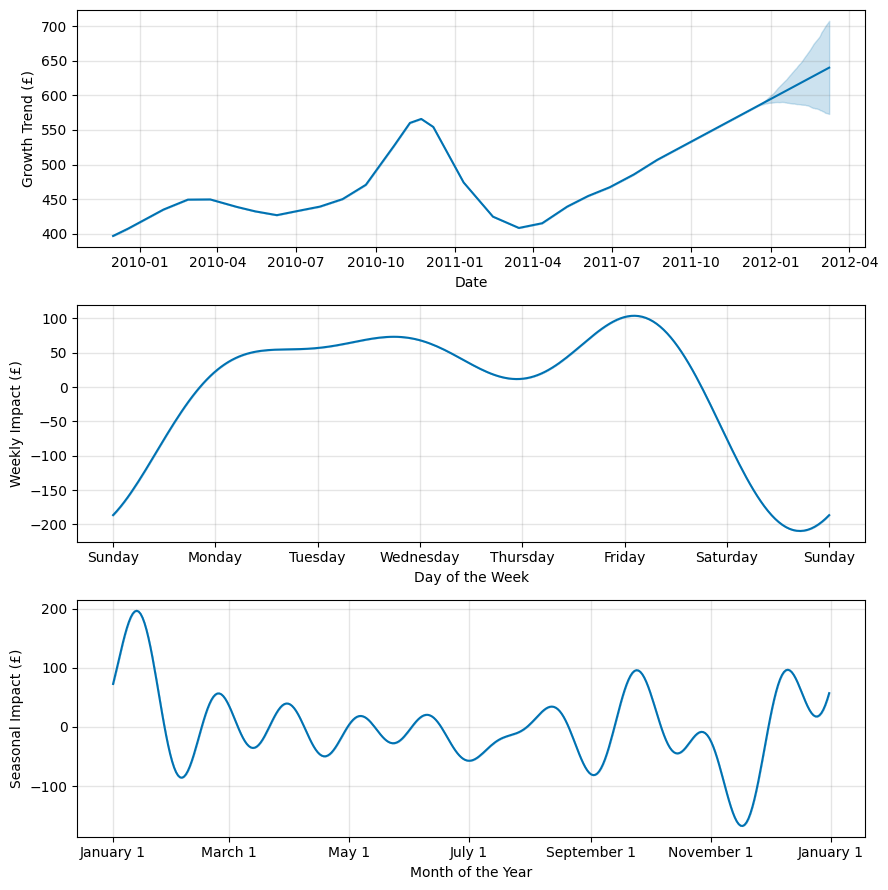

In [10]:
# This generates the Trend, Weekly, and Yearly graphs
model.plot_components(forecast)

import matplotlib.pyplot as plt

# 1. Generate the component plots
fig = model.plot_components(forecast)

# 2. Get the individual axes (Trend, Weekly, Yearly)
axes = fig.get_axes()

# 3. Rename the Y-Axes to Business Terms
axes[0].set_ylabel("Growth Trend (£)")   # The Trend Chart
axes[1].set_ylabel("Weekly Impact (£)")   # The Weekly Chart
axes[2].set_ylabel("Seasonal Impact (£)") # The Yearly Chart

# 4. Rename the X-Axes for clarity
axes[0].set_xlabel("Date")
axes[1].set_xlabel("Day of the Week")
axes[2].set_xlabel("Month of the Year")

plt.show()

In [13]:
# Inventory Alert Example
current_stock = 500  # placeholder
predicted_demand = forecast['yhat'].tail(30).sum() #for the next 30 days

if predicted_demand > current_stock:
    print(f" ALERT: Predicted Demand ({int(predicted_demand)}) exceeds Current Stock ({current_stock}).")
    print(f"Action: Reorder {int(predicted_demand - current_stock)} units immediately.")
else:
    print("Inventory levels healthy for the next 30 days.")

⚠️ ALERT: Predicted Demand (19268) exceeds Current Stock (500).
Action: Reorder 18768 units immediately.
